In [1]:
from utils import *
df = load_dataframe(path="../data/final_data_30_shards")
df = df.fillna(0.0)
print(df.shape)
print(df.columns)

(683254, 75)
Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std',
       'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median',
       'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean',
       'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std',
       'total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'unique_pieces_after_10_white', 'unique_pieces_after_10_black',
       'blunder_counts_white', 'blunder_counts_black'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y_reg_white = df['WhiteElo']
y_reg_black = df['BlackElo']
y_reg_avg = df[['WhiteElo', 'BlackElo']].mean(axis=1)
y_clf_avg = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')

min_elo = int(np.floor(y_reg_avg.min()  / 100) * 100)
max_elo = int(np.ceil (y_reg_avg.max()  / 100) * 100)
# Create bin edges every 100 Elo
bin_edges = np.arange(min_elo, max_elo + 100, 100)

# Labels 0,1,2,... for each 100‑point bin
bin_labels = range(len(bin_edges) - 1)

# Bin with pd.cut (include_lowest so the very minimum is captured)
y_clf_100 = pd.cut(
    y_reg_avg,
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
).astype(int)
# Define the feature matrix (X) by dropping target variables and non-feature columns
categorical = df[['Termination', "ECO"]]
X = df.drop(columns=['WhiteElo', 'BlackElo', 'Result', 'Opening', 'Termination', "ECO"])

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

# 2) One‑hot encode your categorical subset correctly:
categorical_OHE = pd.get_dummies(
    categorical,
    columns=['ECO', 'Termination'],
    drop_first=False
)
X_final = X_scaled.join(categorical_OHE)

X_train, X_test, y_train_clf, y_test_clf = train_test_split(X_final, y_clf_avg, test_size=0.3, random_state=42)

## Gaussian Naive Bayes

GaussianNB Classification Accuracy: 0.11526171228967153
Classification Report:               precision    recall  f1-score   support

           0       0.11      0.98      0.20     20568
           1       0.05      0.01      0.02     20572
           2       0.04      0.01      0.01     20371
           3       0.07      0.01      0.01     20585
           4       0.10      0.01      0.01     20405
           5       0.09      0.01      0.02     20526
           6       0.11      0.01      0.03     20337
           7       0.14      0.01      0.02     20576
           8       0.23      0.02      0.03     20653
           9       0.50      0.08      0.14     20384

    accuracy                           0.12    204977
   macro avg       0.14      0.11      0.05    204977
weighted avg       0.14      0.12      0.05    204977



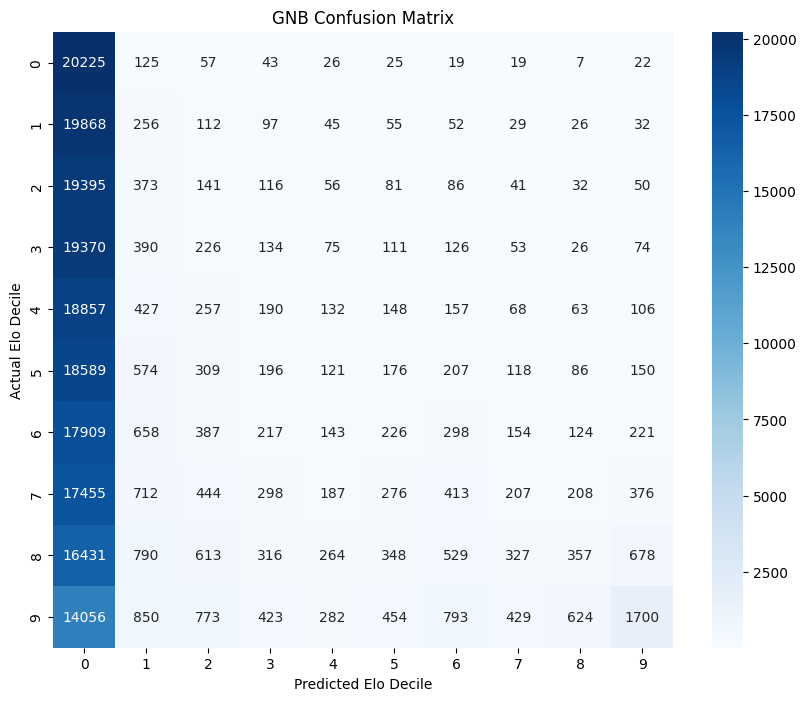

In [4]:
# Import the GaussianNB model
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Initialize and train the GNB classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train_clf)

# Make predictions on the test data
y_pred_gnb = gnb.predict(X_test)

# Evaluate the model's performance
print("GaussianNB Classification Accuracy:", metrics.accuracy_score(y_test_clf, y_pred_gnb))
print("Classification Report:", metrics.classification_report(y_test_clf, y_pred_gnb))

# --- Confusion Matrix Visualization ---
# Compute the confusion matrix to see the model's performance on each class
cm = metrics.confusion_matrix(y_test_clf, y_pred_gnb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('GNB Confusion Matrix')
plt.xlabel('Predicted Elo Decile')
plt.ylabel('Actual Elo Decile')
plt.show()

## Gaussian Discriminant Analysis
### LDA

In [3]:
result = remove_collinear_features(X_final, corr_threshold=0.95)
print("Kept features:", result["selected_features"])
print("Removed log:", result["removed_features"])
reduced_df = result["reduced_df"]


Kept features: ['parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp', 'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median', 'ECO_black_accuracy_cp_mean', 'ECO_black_accuracy_cp_median', 'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median', 'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean', 'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std', 'moves_before_castle_white', 'moves_before_castle_black', 'legal_move_diff_at_25', 'legal_move_diff_at_50', 'legal_move_diff_at_75', 'legal_move_diff_at_100', 'development_before_white', 'development_before_black', 'center_control_after_5_white', 'unique_pieces_after_10_white', 'unique_pieces_after_10_black', 'blunder_counts_white', 'blunder_counts_black', 'first_blunder_move_white', 'first_blunder_move_black', 'mistake_counts_white', 'mistake_counts_black', 'first_mistake_move_white', 'first_mistake_move_black', 'first_win_opportunity_white', 'first_win_opportunity_black', 'first_opp_win_opportun

In [4]:
X_train, X_test, y_train_clf, y_test_clf = train_test_split(reduced_df, y_clf_avg, test_size=0.3, random_state=42)

In [10]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Choose number of clusters (e.g., 10)
n_components = 10
gmm = GaussianMixture(n_components=n_components, random_state=42)
cluster_labels = gmm.fit_predict(X)

# Attach cluster labels to a DataFrame for convenience
clustered_df = pd.DataFrame(X, columns=X.columns)
clustered_df['Cluster'] = cluster_labels

# ----------------------------------------------------------------
# 4) Visualize clusters in 2D via PCA
# ----------------------------------------------------------------
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca2[:, 0], X_pca2[:, 1],
    c=cluster_labels, cmap='tab10', alpha=0.6
)
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.title('GMM Clusters Visualized with PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 5) Visualize clusters in 2D via LDA
# ----------------------------------------------------------------
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda.fit_transform(X, cluster_labels)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_lda2[:, 0], X_lda2[:, 1],
    c=cluster_labels, cmap='tab10', alpha=0.6
)
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.title('GMM Clusters Visualized with LDA (2D)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [12]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


n_components = 10
gmm = GaussianMixture(n_components=n_components, random_state=42)
cluster_labels = gmm.fit_predict(reduced_df)

# Use cluster labels as the target
y = cluster_labels
X_feat = reduced_df.copy() if isinstance(reduced_df, pd.DataFrame) else reduced_df

# Train/test split (stratify so each cluster is represented)
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, random_state=42, stratify=y
)

# Train LDA classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

# Predict on test set and compute accuracy
y_pred = lda_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"LDA test accuracy (recovering GMM clusters): {test_accuracy:.4f}\n")

# Detailed metrics
print("Classification report (test set):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix (test set):")
print(confusion_matrix(y_test, y_pred))

# Optional: 5-fold stratified cross-validation accuracy (gives more stable estimate)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv_scores = cross_val_score(LinearDiscriminantAnalysis(), X_feat, y, cv=cv, scoring='accuracy')
#print(f"\n5-fold CV accuracy: mean = {cv_scores.mean():.4f}, std = {cv_scores.std():.4f}")


LDA test accuracy (recovering GMM clusters): 0.7716

Classification report (test set):
              precision    recall  f1-score   support

           0     0.6914    0.6641    0.6775      9584
           1     0.8176    0.7087    0.7593     40682
           2     0.4351    0.1443    0.2167      1511
           3     0.6409    0.8050    0.7137     30390
           4     0.9573    0.8135    0.8796       193
           5     0.9718    0.9980    0.9847      8871
           6     0.8650    0.8186    0.8412     39110
           7     0.5949    0.6903    0.6391      5716
           8     1.0000    0.9688    0.9841       224
           9     0.9788    0.9973    0.9880       370

    accuracy                         0.7716    136651
   macro avg     0.7953    0.7609    0.7684    136651
weighted avg     0.7804    0.7716    0.7716    136651

Confusion matrix (test set):
[[ 6365   613   191  1160     0     0  1255     0     0     0]
 [  778 28830    67  8127     0     0   450  2430     0     0]

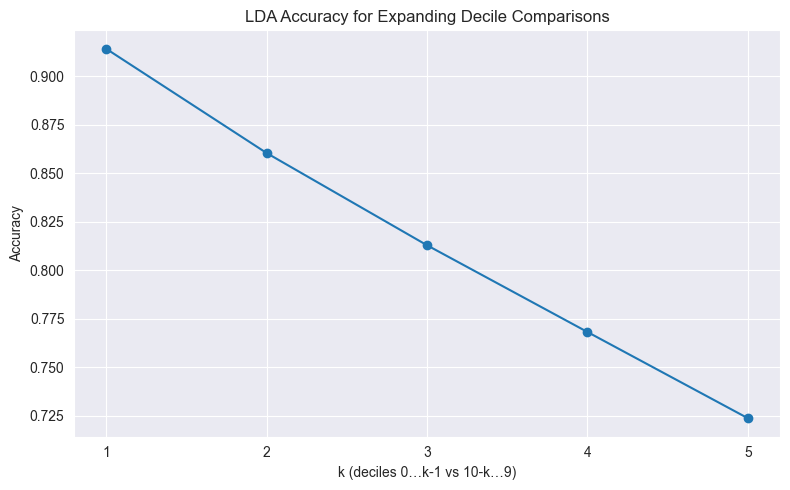

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

# ----------------------------------------------------------------
# 1) Prepare data: X and decile labels
# ----------------------------------------------------------------
# Compute average Elo
y_reg_avg = df[['WhiteElo','BlackElo']].mean(axis=1)

# 10 even deciles
y_clf_decile = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')

# ----------------------------------------------------------------
# 2) Iterate k=1..5 and collect accuracies
# ----------------------------------------------------------------
ks = list(range(1, 6))
accuracies = []

for k in ks:
    # deciles 0…k‑1 as positive, (10‑k)…9 as negative
    pos_bins = list(range(0, k))
    neg_bins = list(range(10-k, 10))
    mask = y_clf_decile.isin(pos_bins + neg_bins)

    # Binary labels
    y_binary = y_clf_decile[mask].map(lambda d: 1 if d in pos_bins else 0)
    X_binary = reduced_df[mask]

    # Train/test split (stratified)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_binary, y_binary,
        test_size=0.3,
        random_state=42,
        stratify=y_binary
    )

    # Train LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_tr, y_tr)
    y_pred = lda.predict(X_te)

    # Record accuracy
    accuracies.append(metrics.accuracy_score(y_te, y_pred))

# ----------------------------------------------------------------
# 3) Plot the results
# ----------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(ks, accuracies, marker='o')
plt.xticks(ks, [f"{k}" for k in ks])
plt.xlabel("k (deciles 0…k-1 vs 10-k…9)")
plt.ylabel("Accuracy")
plt.title("LDA Accuracy for Expanding Decile Comparisons")
plt.grid(True)
plt.tight_layout()
plt.show()


    decile_i  decile_j  accuracy
0          0         1  0.626109
1          0         2  0.689175
2          0         3  0.730547
3          0         4  0.764088
4          0         5  0.795095
5          0         6  0.823776
6          0         7  0.846034
7          0         8  0.876009
8          0         9  0.916356
9          1         2  0.567491
10         1         3  0.617417
11         1         4  0.662225
12         1         5  0.701537
13         1         6  0.739960
14         1         7  0.770260
15         1         8  0.808595
16         1         9  0.869933
17         2         3  0.552475
18         2         4  0.599902
19         2         5  0.641566
20         2         6  0.682911
21         2         7  0.718167
22         2         8  0.763042
23         2         9  0.835365
24         3         4  0.545989
25         3         5  0.590682
26         3         6  0.635747
27         3         7  0.676650
28         3         8  0.725876
29        

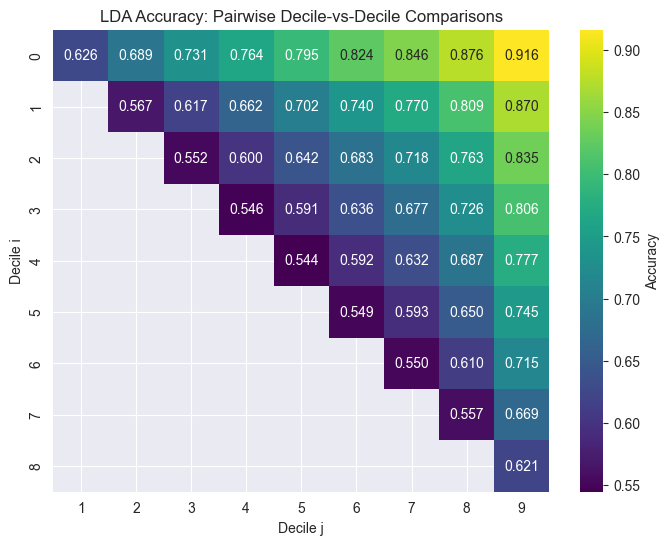

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split

# --- Prepare average-Elo deciles 0–9 and feature matrix X ---
y_reg_avg     = df[['WhiteElo','BlackElo']].mean(axis=1)
y_clf_decile  = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')

# --- Generate all pairs (i,j) with i<j in [0..9] ---
pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]

results = []
for i, j in pairs:
    # select only samples in decile i or j
    mask    = y_clf_decile.isin([i, j])
    X_pair  = reduced_df[mask]
    y_pair  = y_clf_decile[mask].map({i:0, j:1})  # map to binary {0,1}

    # stratified split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_pair, y_pair,
        test_size=0.3,
        random_state=42,
        stratify=y_pair
    )

    # train & evaluate LDA
    lda  = LinearDiscriminantAnalysis()
    lda.fit(X_tr, y_tr)
    y_pr = lda.predict(X_te)
    acc  = metrics.accuracy_score(y_te, y_pr)

    results.append({'decile_i': i, 'decile_j': j, 'accuracy': acc})

# --- Build a DataFrame and pivot into a heatmap-friendly form ---
df_res = pd.DataFrame(results)
heatmap_data = df_res.pivot(index='decile_i', columns='decile_j', values='accuracy')

# --- Display the accuracies table ---
print(df_res)

# --- Plot heatmap of pairwise accuracies ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={'label': 'Accuracy'}
)
plt.title("LDA Accuracy: Pairwise Decile-vs-Decile Comparisons")
plt.xlabel("Decile j")
plt.ylabel("Decile i")
plt.show()


In [8]:
# Cell 1: define the function
import numpy as np
import pandas as pd
from typing import Tuple, Union, Optional
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def fit_lda_accuracy(
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    test_size: float = 0.3,
    random_state: int = 42,
    return_model: bool = False
) -> Union[float, Tuple[float, LinearDiscriminantAnalysis]]:
    """
    Fit Linear Discriminant Analysis (LDA) on X, y and return accuracy on a held-out test set.
    Optionally returns the trained model.

    Parameters
    ----------
    X : DataFrame or ndarray
        Feature matrix.
    y : Series or ndarray
        Labels (binary or multiclass).
    test_size : float
        Fraction of data to keep for testing.
    random_state : int
        Random state for reproducibility.
    return_model : bool
        If True, return (accuracy, trained_model). Otherwise return accuracy only.

    Returns
    -------
    float or (float, model)
        Accuracy on the held-out test set, optionally with the trained LDA model.
    """
    # convert to numpy arrays for sklearn
    X_arr = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
    y_arr = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else np.asarray(y).ravel()

    # determine stratify argument: only use if there are at least 2 classes
    stratify_arg = y_arr if np.unique(y_arr).size > 1 else None

    # attempt stratified split; fall back if stratification fails
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_arr, y_arr,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_arg
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X_arr, y_arr,
            test_size=test_size,
            random_state=random_state,
            stratify=None
        )

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    acc = float(accuracy_score(y_test, y_pred))

    if return_model:
        return acc, lda
    return acc


In [9]:
# Cell 2: example usage (safe to run — only runs demos if variables exist)

# Example 1: using variables from your previous notebook (if available)
try:
    # If reduced_df and y_clf_decile exist in the notebook, run a multiclass LDA
    acc_multiclass = fit_lda_accuracy(reduced_df, y_clf_decile)
    print(f"Multiclass LDA accuracy on (reduced_df, y_clf_decile): {acc_multiclass:.4f}")
except NameError:
    print("Variables 'reduced_df' and/or 'y_clf_decile' not found — skipping multiclass demo.")

# Example 2: single decile pair (replicates your earlier pairwise mapping for one pair)
try:
    i, j = 2, 7  # example deciles; change as needed
    mask = y_clf_decile.isin([i, j])
    X_pair = reduced_df.loc[mask]
    y_pair = y_clf_decile.loc[mask].map({i: 0, j: 1})

    if len(np.unique(y_pair)) > 1 and len(y_pair) >= 10:
        acc_pair = fit_lda_accuracy(X_pair, y_pair)
        print(f"LDA accuracy for deciles {i} vs {j}: {acc_pair:.4f}")
    else:
        print(f"Not enough samples or classes for deciles {i} vs {j} demo — skipping.")
except NameError:
    print("Variables for pairwise demo not found — skipping pairwise demo.")

# Example 3: if you want to run on arbitrary X,y you can do:
# acc = fit_lda_accuracy(X, y)
# or to get the model too:
# acc, model = fit_lda_accuracy(X, y, return_model=True)


Multiclass LDA accuracy on (reduced_df, y_clf_decile): 0.2161
LDA accuracy for deciles 2 vs 7: 0.7182


### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(reg_param=0, )
qda.fit(X_train, y_train_clf)


# Make predictions on the test data
y_pred_qda = qda.predict(X_test)

# Evaluate the model's performance
print("GDA Classification Accuracy:", metrics.accuracy_score(y_test_clf, y_pred_qda))
print("Classification Report:", metrics.classification_report(y_test_clf, y_pred_qda))

# --- Confusion Matrix Visualization ---
# Compute the confusion matrix to see the model's performance on each class
cm = metrics.confusion_matrix(y_test_clf, y_pred_qda)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('QDA Confusion Matrix')
plt.xlabel('Predicted Elo Decile')
plt.ylabel('Actual Elo Decile')
plt.show()

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Choose evaluation mode ---
# Option 1: Vary by number of components
n_components_list = list(range(2, min(X_train.shape[1], 101), 5))  # e.g., from 2 to 100 with step 5

# Option 2: Vary by explained variance
explained_variance_thresholds = [0.90, 0.95, 0.99]

# --- Store results ---
results_by_n = []
results_by_var = []

# --- Evaluation: by number of components ---
for n in n_components_list:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    qda = QuadraticDiscriminantAnalysis(reg_param=0)
    qda.fit(X_train_pca, y_train_clf)
    y_pred = qda.predict(X_test_pca)
    acc = metrics.accuracy_score(y_test_clf, y_pred)

    results_by_n.append((n, acc))

    # --- Evaluation: by explained variance ratio ---
    for var in explained_variance_thresholds:
        pca = PCA(n_components=var)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        qda = QuadraticDiscriminantAnalysis(reg_param=0)
        qda.fit(X_train_pca, y_train_clf)
        y_pred = qda.predict(X_test_pca)
        acc = metrics.accuracy_score(y_test_clf, y_pred)

        results_by_var.append((var, acc, X_train_pca.shape[1]))  # Also track resulting #components



# --- Plot results: Accuracy vs n_components ---
n_vals, acc_vals = zip(*results_by_n)
plt.figure(figsize=(10, 6))
plt.plot(n_vals, acc_vals, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.title("QDA Accuracy vs Number of PCA Components")
plt.grid(True)
plt.show()

# --- Print results for explained variance thresholds ---
print("\n--- Accuracy for PCA by Explained Variance ---")
for var, acc, dims in results_by_var:
    print(f"{int(var*100)}% variance → {dims} components → Accuracy: {acc:.4f}")
